In [1]:
# Imports
import numpy as np
from scipy.special import erf
from scipy.optimize import curve_fit, least_squares
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.interpolate import interp1d
from astropy.table import Table
import matplotlib.colors as colors
from scipy.special import wofz
import spec
%matplotlib inline

In [2]:
spec1,head1 = fits.getdata('specHD7795.fits',header=True)
wave1 = np.arange(head1['NAXIS1'])*head1['CDELT1']+head1['CRVAL1']
if head1['DC-FLAG']==1:
    wave1 = 10**wave1

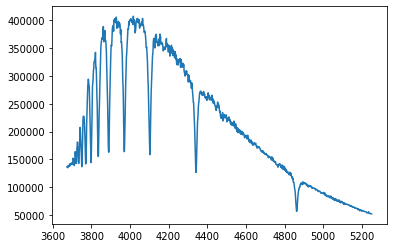

In [3]:
plt.plot(wave1,spec1)

In [4]:
spec2,head2 = fits.getdata('specDI1526.fits',header=True)
wave2 = np.arange(head2['NAXIS1'])*head2['CDELT1']+head2['CRVAL1']
if head2['DC-FLAG']==1:
    wave2 = 10**wave2

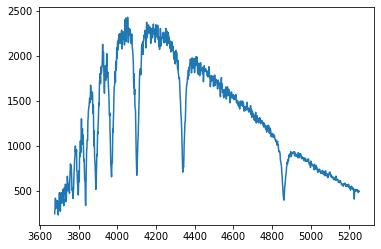

In [5]:
plt.plot(wave2,spec2)

# Continuum normalize

In [6]:
cont1,coef1 = spec.continuum(spec1)

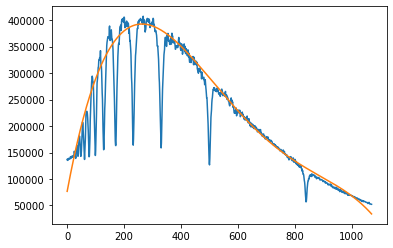

In [7]:
plt.plot(spec1)
plt.plot(cont1)

In [8]:
nspec1 = spec1/cont1

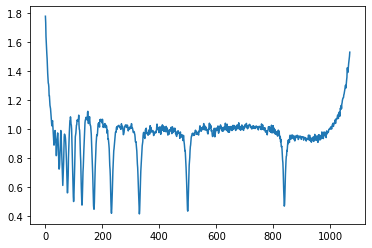

In [9]:
plt.plot(nspec1)

In [10]:
cont2,coef2 = spec.continuum(spec2)

In [11]:
nspec2 = spec2/cont2

(0, 1.5)

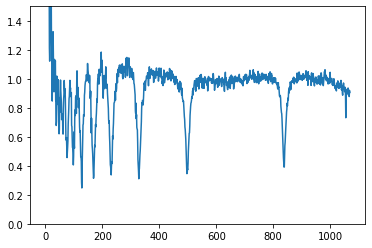

In [13]:
plt.plot(nspec2)
plt.ylim(0,1.5)

In [ ]:
wave1-wave2

(0, 1.2)

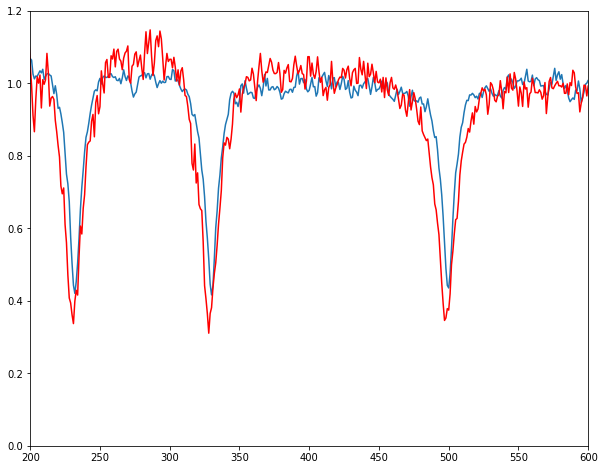

In [14]:
fig = plt.figure(figsize=(10,8))
plt.plot(nspec1)
plt.plot(nspec2,'r')
plt.xlim(200,600)
plt.ylim(0,1.2)

In [15]:
def ccorrelate(x,y,lag):
    """ Cross-Correlation"""
    nx = len(x)
    # Subract mean values
    xd = x-np.mean(x)
    yd = y-np.mean(y)
    nlag = len(lag)
    cross = np.zeros(nlag,dtype=float)
    # Loop over lag points
    for k in range(nlag):
        # Note the reversal of the variables for negative lags.
        if lag[k]>0:
            cross[k] = np.sum(xd[0:nx-lag[k]] * yd[lag[k]:])
        else:
            cross[k] =  np.sum(yd[0:nx+lag[k]] * xd[-lag[k]:])
    cross /= np.sqrt(np.sum(xd**2)*np.sum(yd**2))
    return cross

In [16]:
lag = np.arange(101)-50
print(lag)

[-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50]


In [17]:
lag = np.arange(101)-50
cc = ccorrelate(nspec1[200:600],nspec2[200:600],lag)

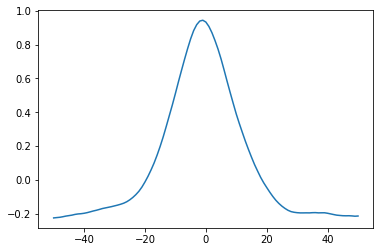

In [18]:
plt.plot(lag,cc)

(0.6, 1)

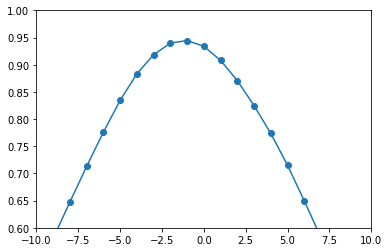

In [19]:
plt.plot(lag,cc)
plt.scatter(lag,cc)
plt.xlim(-10,10)
plt.ylim(0.6,1)

In [20]:
lag[np.argmax(cc)]

-1

In [21]:
pars,cov = spec.gaussfit(lag[40:60],cc[40:60])
gmodel = spec.gaussian(lag,*pars)
print(pars)

[ 0.81522326 -1.01723725  7.37251549  0.12772573]


(0.6, 1)

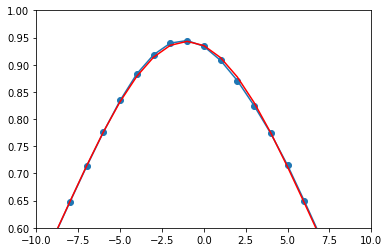

In [22]:
plt.plot(lag,cc)
plt.scatter(lag,cc)
plt.plot(lag,gmodel,'r')
plt.xlim(-10,10)
plt.ylim(0.6,1)

# Synthetic spectra

In [ ]:
wave1

## Color-Temperature Relationship

In [24]:
coef = [-0.452476, 1.27735, -1.16871, 0.885106, 0.507745]

In [25]:
# From Simbad, HD7795 has B-V=-0.080
# From Demers & Irwin (1990) DI1526 has B-V=-0.12

In [26]:
print(5040.0/np.poly1d(coef)(-0.08))
print(5040.0/np.poly1d(coef)(-0.12))

11754.163369558193
13179.855320606526


## 6000 K

In [27]:
sp = fits.getdata('spec.t6000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

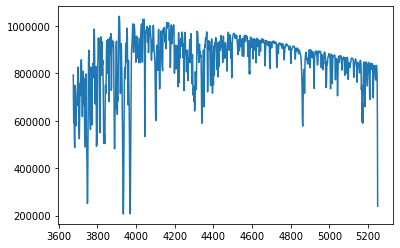

In [30]:
plt.plot(w,sp['flux'])

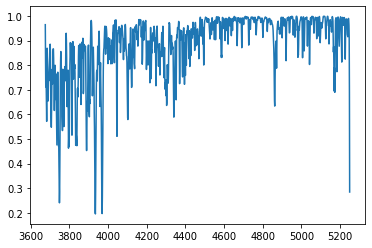

In [31]:
plt.plot(w,sp['flux']/sp['cont'])

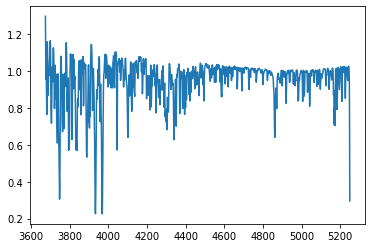

In [32]:
plt.plot(w,s2)

(0, 1.2)

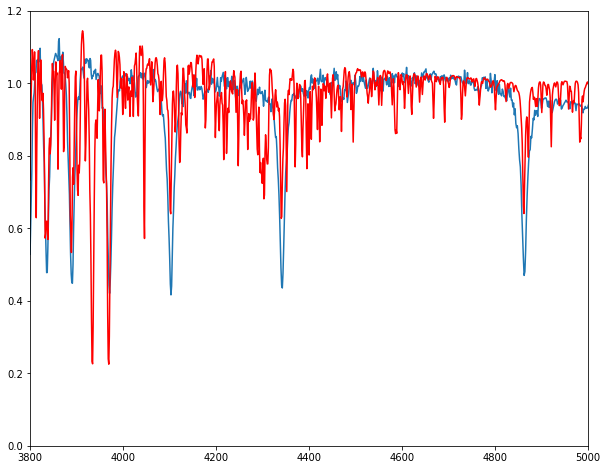

In [33]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 8000 K

In [34]:
sp = fits.getdata('spec.t8000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

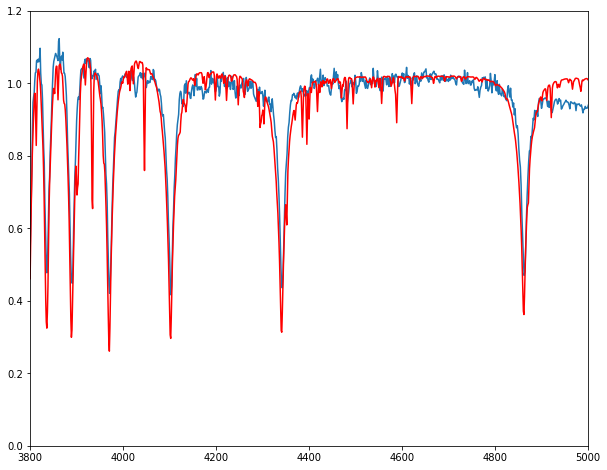

In [35]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 10000 K

In [36]:
sp = fits.getdata('spec.t10000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

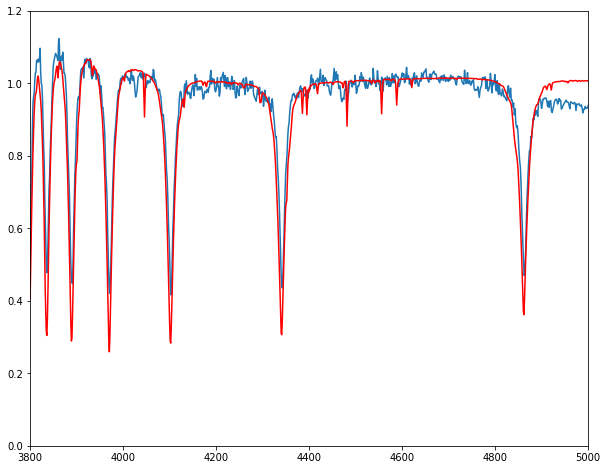

In [37]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 12000 K

In [38]:
sp = fits.getdata('spec.t12000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

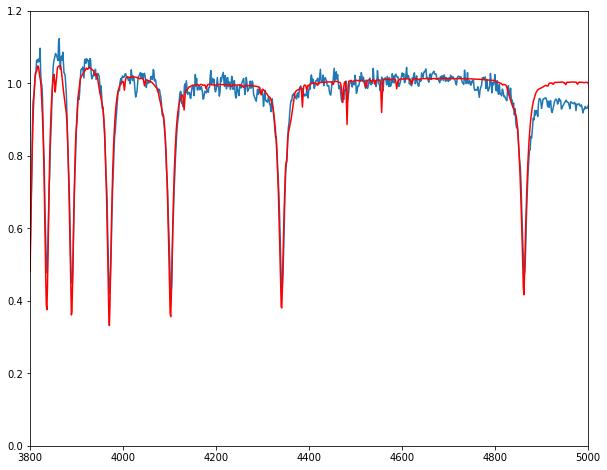

In [39]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## 14000 K

In [40]:
sp = fits.getdata('spec.t14000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

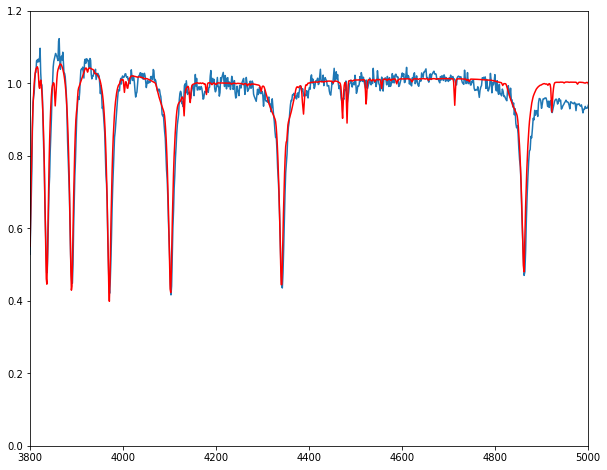

In [41]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = 0.0

In [42]:
sp = fits.getdata('spec.t12000g4.00m+0.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

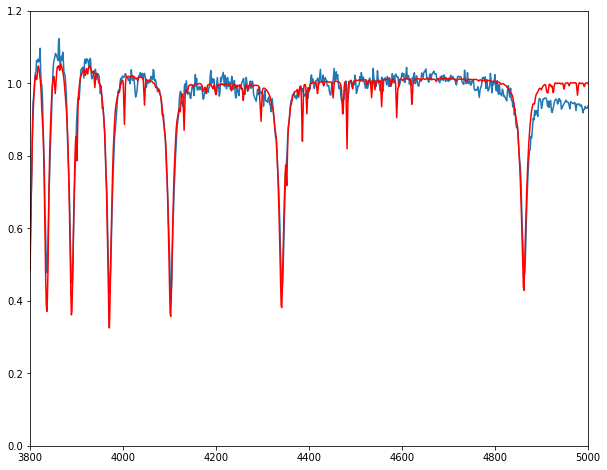

In [43]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -0.5

In [44]:
sp = fits.getdata('spec.t12000g4.00m-0.50.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

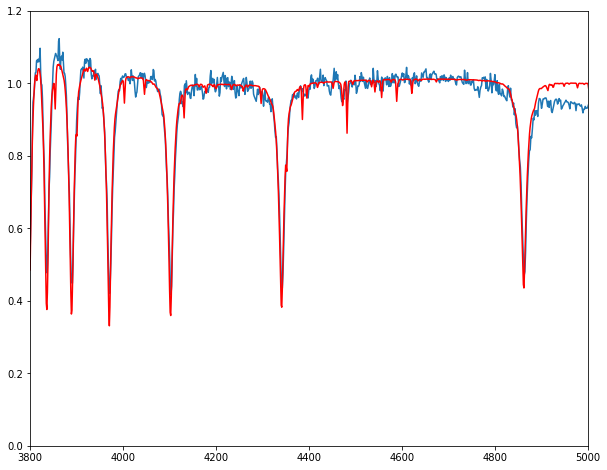

In [45]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -1.0

In [46]:
sp = fits.getdata('spec.t12000g4.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

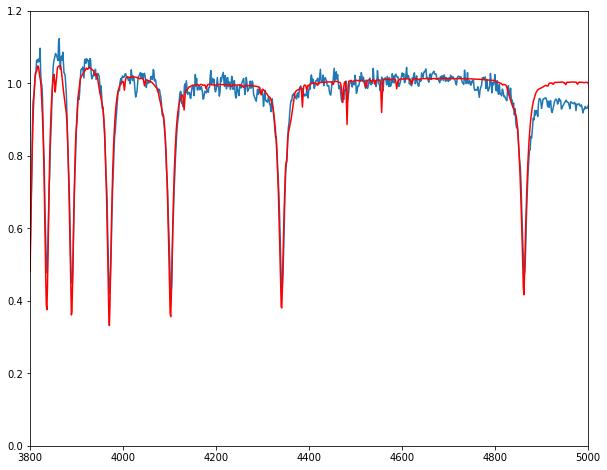

In [47]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -1.5

In [48]:
sp = fits.getdata('spec.t12000g4.00m-1.50.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

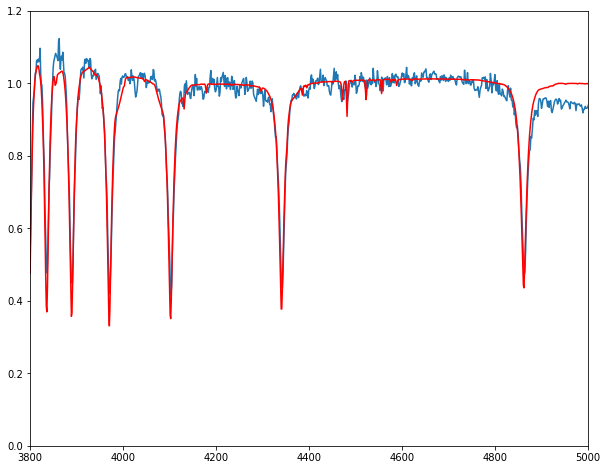

In [51]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

## [Fe/H] = -2.0

In [52]:
sp = fits.getdata('spec.t12000g4.00m-2.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

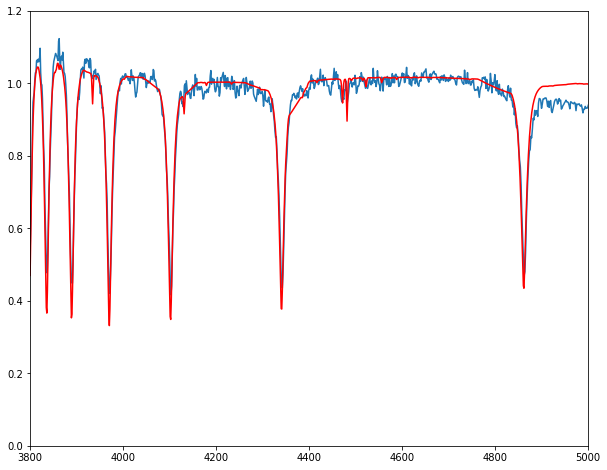

In [53]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

In [54]:
sp = fits.getdata('spec.t10000g3.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

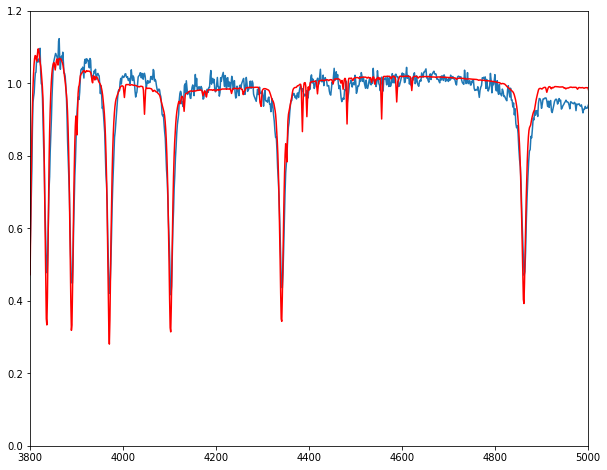

In [55]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)

In [56]:
sp = fits.getdata('spec.t10000g5.00m-1.00.fits.gz')
w = sp['wave']
s = sp['flux']/sp['cont']
c,ccoef = spec.continuum(s)
s2 = s/c

(0, 1.2)

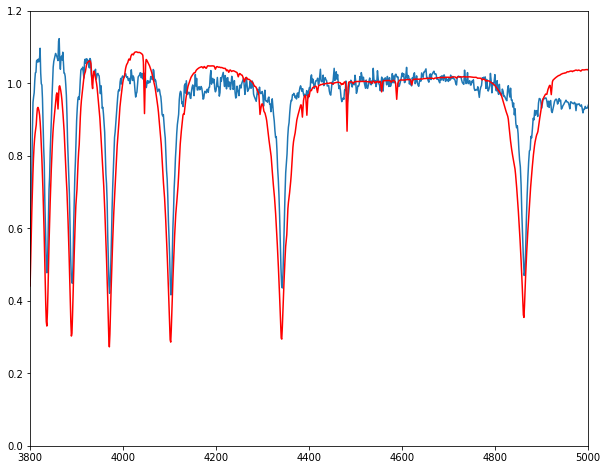

In [57]:
fig = plt.figure(figsize=(10,8))
plt.plot(wave1,nspec1)
plt.plot(w,s2,'r')
plt.xlim(3800,5000)
plt.ylim(0,1.2)